# Snowpark Traveling Salesman Problem

In [1]:
# Snowpark Imports
import json
from decimal import Decimal
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

#
import pandas as pd
import networkx as nx
import itertools
from typing import Iterable, Tuple
import matplotlib.pyplot as plt

# Reading Snowflake Connection Details
snowflake_connection_cfg = open('../snowflake_setup/snowflake_connection.json')
snowflake_connection_cfg = snowflake_connection_cfg.read()
snowflake_connection_cfg = json.loads(snowflake_connection_cfg)

# Creating Snowpark Session
session = Session.builder.configs(snowflake_connection_cfg).create()
print('Current Database:', session.get_current_database())
print('Current Schema:', session.get_current_schema())
print('Current Warehouse:', session.get_current_warehouse())

Current Database: "SNOWPARK_DEMO_DB"
Current Schema: "PUBLIC"
Current Warehouse: "SNOWPARK_DEMO_WH"


### Traveling Salesman Problem with NetworkX

In [2]:
# Creating a Graph
graph = nx.Graph()
graph.add_edge('A','B', weight=1)
graph.add_edge('A','H', weight=1)
graph.add_edge('B','C', weight=1)
graph.add_edge('C','D', weight=3)
graph.add_edge('D','E', weight=1)
graph.add_edge('E','F', weight=5) # -> this heavy-weight path should be excluded by the algorithm
graph.add_edge('F','G', weight=1)
graph.add_edge('G','H', weight=1)

# Running the traveling salesman problem algorithm
tsp = nx.approximation.traveling_salesman_problem
# path = tsp(graph, nodes=['C', 'F'], cycle=False) # shortes route from node C to node F
path = tsp(graph, nodes=['A','B','C','D','E','F','G','H'], cycle=False,) # shortest route between all nodes
path_edges = list(zip(path,path[1:]))

# Function to construct list of tuples as return
def ret_tuples(graph,res):
    path_edges = list(zip(res,res[1:]))
    path_edges = [val+(graph.get_edge_data(val[0],val[1])['weight'],) for val in path_edges]
    return path_edges

ret_tuples(graph, path)

[('E', 'D', 1),
 ('D', 'C', 3),
 ('C', 'B', 1),
 ('B', 'A', 1),
 ('A', 'H', 1),
 ('H', 'G', 1),
 ('G', 'F', 1)]

{('A', 'B'): Text(-0.7227090494508568, -0.579191575292378, '1'),
 ('A', 'H'): Text(-0.9502147518639019, 0.09817598603188826, '1'),
 ('B', 'C'): Text(-0.03208074951036241, -0.8570927632067203, '1'),
 ('H', 'G'): Text(-0.561053603586757, 0.7013616175169108, '1'),
 ('C', 'D'): Text(0.5692922629368629, -0.6664838935750064, '3'),
 ('D', 'E'): Text(0.7966820139914726, -0.05687381240797809, '1'),
 ('E', 'F'): Text(0.7144703901007509, 0.5443138513504733, '5'),
 ('F', 'G'): Text(0.18561348738279157, 0.8157905895828099, '1')}

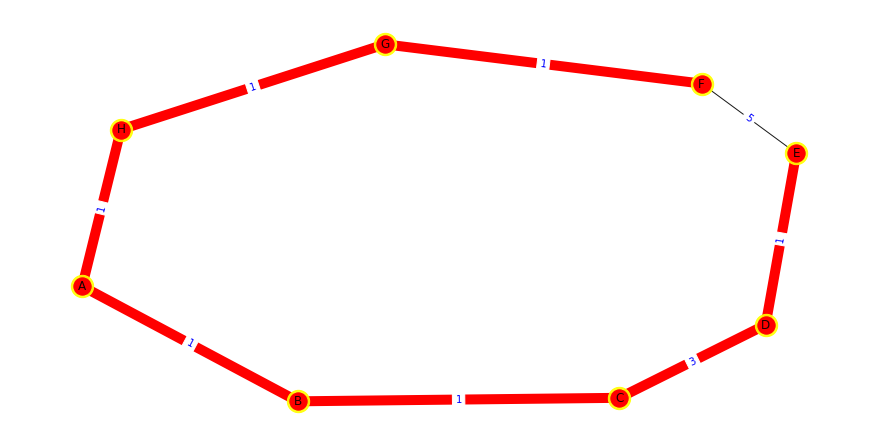

In [3]:
# Visualize Graph
pos = nx.spring_layout(graph)
plt.figure(figsize=(12,6))
nx.draw(
    graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='yellow', alpha=0.9,
    labels={node: node for node in graph.nodes()}
)
# Drawing Shortes Route
nx.draw_networkx_nodes(graph,pos,nodelist=path,node_color='r')
nx.draw_networkx_edges(graph,pos,edgelist=path_edges,edge_color='r',width=10)

# Drawing Edge Labels
edge_labels = dict([((n1, n2), graph.get_edge_data(n1,n2)['weight'])
                    for n1, n2 in graph.edges])
nx.draw_networkx_edge_labels(
    graph, pos,
    edge_labels=edge_labels,
    font_color='blue'
)

In [4]:
# Define class for UDTF
class TravelingSalesmanProblem:
    def __init__(self):
        self.graph = nx.Graph()
        
    # In each iteration we are adding edges to our graph
    def process(self, left: str, right: str, weight: int, nodes: list) -> Iterable[Tuple[str, str, int]]:
        self.graph.add_edge(left, right, weight=weight)
        self.nodes = nodes
        return None
        
    # After the graph is built completely we are running the TSP algorithm
    def end_partition(self):
        tsp = nx.approximation.traveling_salesman_problem
        path = tsp(self.graph, nodes=self.nodes, cycle=True)
        res = self.ret_tuples(path)
        return res
    
    def ret_tuples(self,res):
        path_edges = list(zip(res,res[1:]))
        path_edges = [val+(self.graph.get_edge_data(val[0],val[1])['weight'],) for val in path_edges]
        return path_edges

In [5]:
# Register UDTF
tsp_udtf = session.udtf.register(TravelingSalesmanProblem, ["SRC", "DST", "DISTANCE"], 
                                 name='tsp', 
                                 is_permanent=True, 
                                 stage_location='@MY_FUNCTIONS', 
                                 replace=True, 
                                 packages=['numpy'],
                                 imports=['/opt/conda/envs/pysnowpark/lib/python3.8/site-packages/networkx/'])

In [6]:
# Generate some Testdata
data = [
    ['GROUP1','A','B', 1],
    ['GROUP1','A','H', 1],
    ['GROUP1','B','C', 1],
    ['GROUP1','C','D', 3],
    ['GROUP1','D','E', 1],
    ['GROUP1','E','F', 5],
    ['GROUP1','F','G', 1],
    ['GROUP1','G','H', 1],
]
data = pd.DataFrame(data, columns=['GROUP', 'LEFT', 'RIGHT', 'DISTANCE_LEFT_RIGHT'])
session.sql('DROP TABLE IF EXISTS TSP_TESTDATA').collect()
session.write_pandas(data, 'TSP_TESTDATA', auto_create_table=True)
df = session.table('TSP_TESTDATA')
df.show()

------------------------------------------------------
|"GROUP"  |"LEFT"  |"RIGHT"  |"DISTANCE_LEFT_RIGHT"  |
------------------------------------------------------
|GROUP1   |A       |B        |1                      |
|GROUP1   |A       |H        |1                      |
|GROUP1   |B       |C        |1                      |
|GROUP1   |C       |D        |3                      |
|GROUP1   |D       |E        |1                      |
|GROUP1   |E       |F        |5                      |
|GROUP1   |F       |G        |1                      |
|GROUP1   |G       |H        |1                      |
------------------------------------------------------



In [7]:
# Calling our UDTF
tsp_result = df.join_table_function(tsp_udtf(df['LEFT'], 
                                             df['RIGHT'],
                                             df['DISTANCE_LEFT_RIGHT'], 
                                             F.array_construct(F.lit('A'),F.lit('D'))).over(partition_by="GROUP", order_by="GROUP"))
tsp_result.select('GROUP','SRC','DST','DISTANCE').show()

----------------------------------------
|"GROUP"  |"SRC"  |"DST"  |"DISTANCE"  |
----------------------------------------
|GROUP1   |A      |B      |1           |
|GROUP1   |B      |C      |1           |
|GROUP1   |C      |D      |3           |
|GROUP1   |D      |C      |3           |
|GROUP1   |C      |B      |1           |
|GROUP1   |B      |A      |1           |
----------------------------------------



### (Real) World Example: Beergarden Route Optimization
Let's try a real world example!<br>
Munich has a lot of places where you can enjoy a cold beer but my time is limited.<br>
Therefore I'd like to get the shortest route that visits all the places and starts/ends from my home address.

In [8]:
import requests
import urllib.parse
from geojson import Point

# Getting LAT/LON from openstreetmap
def get_point(address):
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    response = requests.get(url).json()
    return Point([float(response[0]["lat"]), float(response[0]["lon"])])

# List of locations
data = [
    ['Home','Rudliebstrasse 1, 81925, Munich'],
    ['Augustiner-Keller','Arnulfstraße 52, 80335, Munich'],
    ['Chinesischer Turm','Englischer Garten 3 80538, 80538, Munich'],
    ['Seehaus im Englischen Garten','Kleinhesselohe 3, 80802, Munich'],
    ['Hirschgarten','Hirschgarten 1, 80639, Munich'],
    ['Hofbräuhaus','Platzl 9, 80331, Munich'],
    ['Paulaner am Nockherberg','Hochstraße 77, 81541, Munich'],
    ['Paulaner Bräuhaus','Kapuzinerpl. 5, 80337, Munich']
]
data = pd.DataFrame(data, columns=['DESCRIPTION','ADDRESS'])
data['POINT'] = data.apply(lambda row: get_point(row['ADDRESS']), axis='columns')
data

,DESCRIPTION,ADDRESS,POINT
0,Home,"Rudliebstrasse 1, 81925, Munich","{'type': 'Point', 'coordinates': [48.155079, 1..."
1,Augustiner-Keller,"Arnulfstraße 52, 80335, Munich","{'type': 'Point', 'coordinates': [48.14354, 11..."
2,Chinesischer Turm,"Englischer Garten 3 80538, 80538, Munich","{'type': 'Point', 'coordinates': [48.152052, 1..."
3,Seehaus im Englischen Garten,"Kleinhesselohe 3, 80802, Munich","{'type': 'Point', 'coordinates': [48.160516, 1..."
4,Hirschgarten,"Hirschgarten 1, 80639, Munich","{'type': 'Point', 'coordinates': [48.149852, 1..."
5,Hofbräuhaus,"Platzl 9, 80331, Munich","{'type': 'Point', 'coordinates': [48.137571, 1..."
6,Paulaner am Nockherberg,"Hochstraße 77, 81541, Munich","{'type': 'Point', 'coordinates': [48.121751, 1..."
7,Paulaner Bräuhaus,"Kapuzinerpl. 5, 80337, Munich","{'type': 'Point', 'coordinates': [48.12634, 11..."


In [9]:
# Write data to Snowflake
session.sql('DROP TABLE IF EXISTS BEERTOUR').collect()
session.write_pandas(data, 'BEERTOUR', auto_create_table=True)
df = session.table('BEERTOUR')
# Transform coordinates to geography data type for distance calculation
df = df.with_column('POINT', F.to_geography('POINT'))
df.toPandas()

,DESCRIPTION,ADDRESS,POINT
0,Home,"Rudliebstrasse 1, 81925, Munich","{\n ""coordinates"": [\n 4.815507900000000e+..."
1,Augustiner-Keller,"Arnulfstraße 52, 80335, Munich","{\n ""coordinates"": [\n 4.814354000000000e+..."
2,Chinesischer Turm,"Englischer Garten 3 80538, 80538, Munich","{\n ""coordinates"": [\n 4.815205200000000e+..."
3,Seehaus im Englischen Garten,"Kleinhesselohe 3, 80802, Munich","{\n ""coordinates"": [\n 4.816051600000000e+..."
4,Hirschgarten,"Hirschgarten 1, 80639, Munich","{\n ""coordinates"": [\n 4.814985200000000e+..."
5,Hofbräuhaus,"Platzl 9, 80331, Munich","{\n ""coordinates"": [\n 4.813757100000000e+..."
6,Paulaner am Nockherberg,"Hochstraße 77, 81541, Munich","{\n ""coordinates"": [\n 4.812175100000000e+..."
7,Paulaner Bräuhaus,"Kapuzinerpl. 5, 80337, Munich","{\n ""coordinates"": [\n 4.812634000000000e+..."


In [10]:
# Get all locations
locations = df.select('DESCRIPTION').collect()

# Loop through all locations and perform cross-joins to retrieve all possible edges
def get_all_edges(locations, df):
    df_locations = None
    for location in locations:
        if df_locations == None:
            # First Location
            df_locations = df.select(F.col('DESCRIPTION').as_("START"), F.col('POINT').as_('POINT1'))
        else:
            # Other Locations
            df_locations = df.cross_join(df.select(F.col('DESCRIPTION').as_("END"), F.col('POINT').as_('POINT2')))
    df_locations = df_locations.select(F.col('DESCRIPTION').as_('START'), 'POINT', 'END', 'POINT2')
    # Remove edges where start and end are the same
    df_locations = df_locations.filter(F.col('START') != F.col('END'))
    return df_locations
res = get_all_edges(locations, df)
# Calculate the distances with builtin function
res = res.with_column('DISTANCE_POINT1_POINT2', F.call_builtin('ST_DISTANCE', F.col('POINT'), F.col('POINT2')))
res = res.with_column('GROUP', F.lit('GROUP1'))
res.toPandas()

,START,POINT,END,POINT2,DISTANCE_POINT1_POINT2,GROUP
0,Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",Augustiner-Keller,"{\n ""coordinates"": [\n 4.814354000000000e+...",6998.556120,GROUP1
1,Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",Chinesischer Turm,"{\n ""coordinates"": [\n 4.815205200000000e+...",2403.189627,GROUP1
2,Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",Seehaus im Englischen Garten,"{\n ""coordinates"": [\n 4.816051600000000e+...",1830.632716,GROUP1
3,Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",Hirschgarten,"{\n ""coordinates"": [\n 4.814985200000000e+...",11445.696677,GROUP1
4,Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",Hofbräuhaus,"{\n ""coordinates"": [\n 4.813757100000000e+...",4226.749001,GROUP1
5,Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",Paulaner am Nockherberg,"{\n ""coordinates"": [\n 4.812175100000000e+...",5033.260683,GROUP1
6,Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",Paulaner Bräuhaus,"{\n ""coordinates"": [\n 4.812634000000000e+...",6873.857989,GROUP1
7,Augustiner-Keller,"{\n ""coordinates"": [\n 4.814354000000000e+...",Home,"{\n ""coordinates"": [\n 4.815507900000000e+...",6998.556120,GROUP1
8,Augustiner-Keller,"{\n ""coordinates"": [\n 4.814354000000000e+...",Chinesischer Turm,"{\n ""coordinates"": [\n 4.815205200000000e+...",4598.742956,GROUP1
9,Augustiner-Keller,"{\n ""coordinates"": [\n 4.814354000000000e+...",Seehaus im Englischen Garten,"{\n ""coordinates"": [\n 4.816051600000000e+...",5474.359683,GROUP1


In [11]:
# get all locations in list (first value will be start+end a.k.a circle back home)
locs = [F.lit(val[0]) for val in locations]
print('Start and End will be:', locations[0][0])

# get the shortest route
tsp_result = res.join_table_function(tsp_udtf(res["START"], 
                                             res['END'], 
                                             F.to_decimal(res['DISTANCE_POINT1_POINT2'], 38, 0), 
                                             F.array_construct(*locs)).over(partition_by="GROUP", order_by="GROUP"))
tsp_result = tsp_result.select('GROUP','SRC','DST','DISTANCE')
tsp_result.toPandas()

Start and End will be: Home


,GROUP,SRC,DST,DISTANCE
0,GROUP1,Home,Hofbräuhaus,4227
1,GROUP1,Hofbräuhaus,Paulaner am Nockherberg,1747
2,GROUP1,Paulaner am Nockherberg,Hirschgarten,8515
3,GROUP1,Hirschgarten,Augustiner-Keller,4598
4,GROUP1,Augustiner-Keller,Paulaner Bräuhaus,2024
5,GROUP1,Paulaner Bräuhaus,Chinesischer Turm,4672
6,GROUP1,Chinesischer Turm,Seehaus im Englischen Garten,1127
7,GROUP1,Seehaus im Englischen Garten,Home,1831


In [12]:
# Total Distance
tsp_result.select(F.sum('DISTANCE').as_('TOTAL_DISTANCE')).toPandas()

,TOTAL_DISTANCE
0,28741


In [13]:
# Add addresses and points back to our results
# Left-side (SRC)
finals = tsp_result.join(df, tsp_result.SRC == df.DESCRIPTION)
finals = finals.with_column_renamed(F.col("POINT"), "POINT1")
finals = finals.with_column_renamed(F.col("ADDRESS"), "ADDRESS1")
finals = finals.drop('DESCRIPTION')
# Right-side (DST)
finals = finals.join(df, finals.DST == df.DESCRIPTION)
finals = finals.with_column_renamed(F.col("POINT"), "POINT2")
finals = finals.with_column_renamed(F.col("ADDRESS"), "ADDRESS2")
finals = finals.drop('DESCRIPTION')
finals.toPandas()

,GROUP,SRC,DST,DISTANCE,ADDRESS1,POINT1,ADDRESS2,POINT2
0,GROUP1,Home,Hofbräuhaus,4227,"Rudliebstrasse 1, 81925, Munich","{\n ""coordinates"": [\n 4.815507900000000e+...","Platzl 9, 80331, Munich","{\n ""coordinates"": [\n 4.813757100000000e+..."
1,GROUP1,Hofbräuhaus,Paulaner am Nockherberg,1747,"Platzl 9, 80331, Munich","{\n ""coordinates"": [\n 4.813757100000000e+...","Hochstraße 77, 81541, Munich","{\n ""coordinates"": [\n 4.812175100000000e+..."
2,GROUP1,Paulaner am Nockherberg,Hirschgarten,8515,"Hochstraße 77, 81541, Munich","{\n ""coordinates"": [\n 4.812175100000000e+...","Hirschgarten 1, 80639, Munich","{\n ""coordinates"": [\n 4.814985200000000e+..."
3,GROUP1,Hirschgarten,Augustiner-Keller,4598,"Hirschgarten 1, 80639, Munich","{\n ""coordinates"": [\n 4.814985200000000e+...","Arnulfstraße 52, 80335, Munich","{\n ""coordinates"": [\n 4.814354000000000e+..."
4,GROUP1,Augustiner-Keller,Paulaner Bräuhaus,2024,"Arnulfstraße 52, 80335, Munich","{\n ""coordinates"": [\n 4.814354000000000e+...","Kapuzinerpl. 5, 80337, Munich","{\n ""coordinates"": [\n 4.812634000000000e+..."
5,GROUP1,Paulaner Bräuhaus,Chinesischer Turm,4672,"Kapuzinerpl. 5, 80337, Munich","{\n ""coordinates"": [\n 4.812634000000000e+...","Englischer Garten 3 80538, 80538, Munich","{\n ""coordinates"": [\n 4.815205200000000e+..."
6,GROUP1,Chinesischer Turm,Seehaus im Englischen Garten,1127,"Englischer Garten 3 80538, 80538, Munich","{\n ""coordinates"": [\n 4.815205200000000e+...","Kleinhesselohe 3, 80802, Munich","{\n ""coordinates"": [\n 4.816051600000000e+..."
7,GROUP1,Seehaus im Englischen Garten,Home,1831,"Kleinhesselohe 3, 80802, Munich","{\n ""coordinates"": [\n 4.816051600000000e+...","Rudliebstrasse 1, 81925, Munich","{\n ""coordinates"": [\n 4.815507900000000e+..."


In [14]:
# Visualize data using Google Maps
# Note: Keep in mind that we optimized using ST_DISTANCE which returns the 
# geodesic distance, NOT the real distance using roads.
import gmaps
import gmaps.datasets

# Setup API
# https://developers.google.com/maps/documentation/embed/get-api-key -> 200$/Month free usage
api_key = 'AIz....'
gmaps.configure(api_key=api_key)

# Get data to plot (gmaps expects tuples of (lat/lon))
# Transform Points to Lat/Lon
route = finals.select(F.call_builtin('ST_X', F.col('POINT1')).as_('LAT'),
                      F.call_builtin('ST_Y', F.col('POINT1')).as_('LON')).toPandas()
route

# Generate tuples
records = list(route.to_records(index=False))
start = records[0]
end = (start[0], start[1] - 0.001) # easier to visualize with slightly different start/end point
waypoints = records[1:]

# Plot the data
fig = gmaps.figure(map_type='SATELLITE')
beergarden_route = gmaps.directions_layer(
    start, end, waypoints=waypoints,
    travel_mode='WALKING', stroke_opacity=1)
fig.add_layer(beergarden_route)
fig

Figure(layout=FigureLayout(height='420px'))